In [1]:
import pandas as pd
import numpy as np
import glob
import os

# CSV 파일 경로 로드
file_paths = sorted(glob.glob('papaya_data/*.csv'))  # 폴더명 필요 시 수정
all_data = []

for file in file_paths:
    df = pd.read_csv(file)

    # ✅ 'Back' 클래스 제거
    if 'Back' in df.iloc[:, -1].unique():
        before = len(df)
        df = df[df.iloc[:, -1] != 'Back']
        after = len(df)
        print(f"{os.path.basename(file)}: 'Back' 제거됨 ({before - after}개)")

    all_data.append(df)

# 전체 병합
data_all = pd.concat(all_data, axis=0).reset_index(drop=True)
print(f"전체 시점 수 (Back 제거 후): {len(data_all)}")


avg_100ms_Jade_s23_pedLog_1754295834137.csv: 'Back' 제거됨 (209개)
avg_100ms_gracie2_s23_pedLog_1754295826889.csv: 'Back' 제거됨 (57개)
avg_100ms_gracie_s23_pedLog_1754295955777.csv: 'Back' 제거됨 (140개)
전체 시점 수 (Back 제거 후): 10685


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🔹 방향각의 변화량 (delta azimuth) 추가
azimuth_rad = np.radians(data_all['azimuth'])
delta_azimuth = np.diff(azimuth_rad, prepend=azimuth_rad.iloc[0])
delta_azimuth = (delta_azimuth + np.pi) % (2 * np.pi) - np.pi  # [-π, π] 범위로 정규화
data_all['dAzimuth'] = delta_azimuth

# 🔹 sin, cos 변환
data_all['azimuth_sin'] = np.sin(azimuth_rad)
data_all['azimuth_cos'] = np.cos(azimuth_rad)

# 🔹 가속도 변화량
for axis in ['X', 'Y', 'Z']:
    col = f'accel{axis}'
    dcol = f'dAccel{axis}'
    data_all[dcol] = data_all[col].diff().fillna(0)

# 🔹 정규화 대상 선정
exclude_cols = ['timestamp', 'timestamp_offset', 'direction', 'azimuth']
feature_cols = [col for col in data_all.columns if col not in exclude_cols]

# 🔹 정규화
scaler = StandardScaler()
data_all[feature_cols] = scaler.fit_transform(data_all[feature_cols])

# 🔹 사용하지 않는 열 제거
data_all = data_all.drop(columns=['timestamp', 'timestamp_offset', 'azimuth'])
data_all = data_all[[col for col in data_all.columns if col != 'direction'] + ['direction']]


In [3]:
from sklearn.preprocessing import LabelEncoder

window_size = 5
X_all, y_all = [], []

label_encoder = LabelEncoder()
label_encoder.fit(data_all['direction'].astype(str))
print("클래스 매핑:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

for i in range(len(data_all) - window_size + 1):
    window = data_all.iloc[i:i+window_size]
    features = window.iloc[:, :-1].values.astype(np.float32)
    label_mode_str = window['direction'].mode()[0]
    label_encoded = label_encoder.transform([label_mode_str])[0]
    X_all.append(features)
    y_all.append(label_encoded)

X_all = np.array(X_all)
y_all = np.array(y_all)
print(f"슬라이딩 윈도우 수: {len(X_all)}, 입력 형태: {X_all.shape}")


클래스 매핑: {'Front': 0, 'Left': 1, 'Right': 2, 'Stay': 3}
슬라이딩 윈도우 수: 10681, 입력 형태: (10681, 5, 18)


In [4]:
from sklearn.model_selection import StratifiedKFold

# ✅ 3D → 2D flatten (SVM용)
X_flat = X_all.reshape(X_all.shape[0], -1)
y_flat = y_all.copy()

# ✅ Fold 생성
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
folds = list(skf.split(X_flat, y_flat))

# ✅ 누적 저장용
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
CM_total = np.zeros((len(label_encoder.classes_), len(label_encoder.classes_)), dtype=int)
preds_all, targets_all = [], []



===== Fold 0 =====
              precision    recall  f1-score   support

       Front     0.8726    0.9825    0.9243      1541
        Left     0.8636    0.6552    0.7451       174
       Right     0.9449    0.5769    0.7164       208
        Stay     0.8811    0.5888    0.7059       214

    accuracy                         0.8769      2137
   macro avg     0.8906    0.7008    0.7729      2137
weighted avg     0.8798    0.8769    0.8676      2137



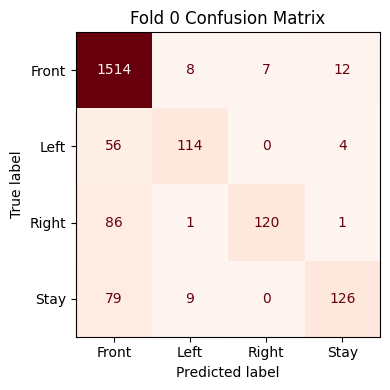


===== Fold 1 =====
              precision    recall  f1-score   support

       Front     0.8625    0.9766    0.9160      1541
        Left     0.8720    0.6301    0.7315       173
       Right     0.9375    0.5048    0.6562       208
        Stay     0.8117    0.5841    0.6793       214

    accuracy                         0.8633      2136
   macro avg     0.8709    0.6739    0.7458      2136
weighted avg     0.8655    0.8633    0.8521      2136



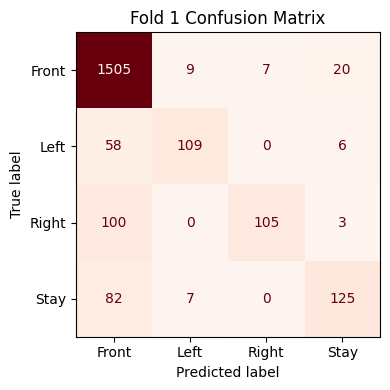


===== Fold 2 =====
              precision    recall  f1-score   support

       Front     0.8695    0.9812    0.9220      1541
        Left     0.9023    0.6936    0.7843       173
       Right     0.9449    0.5769    0.7164       208
        Stay     0.8905    0.5701    0.6952       214

    accuracy                         0.8773      2136
   macro avg     0.9018    0.7055    0.7795      2136
weighted avg     0.8816    0.8773    0.8681      2136



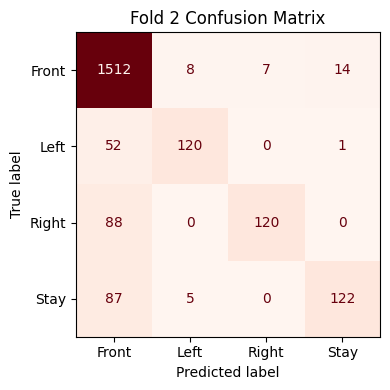


===== Fold 3 =====
              precision    recall  f1-score   support

       Front     0.8724    0.9812    0.9236      1540
        Left     0.8978    0.7110    0.7935       173
       Right     0.9242    0.5837    0.7155       209
        Stay     0.8815    0.5561    0.6819       214

    accuracy                         0.8778      2136
   macro avg     0.8940    0.7080    0.7787      2136
weighted avg     0.8804    0.8778    0.8685      2136



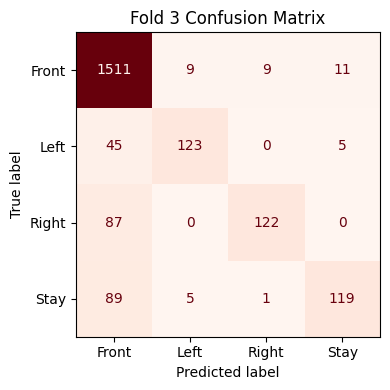


===== Fold 4 =====
              precision    recall  f1-score   support

       Front     0.8594    0.9838    0.9174      1541
        Left     0.8968    0.6494    0.7533       174
       Right     0.9528    0.4856    0.6433       208
        Stay     0.8786    0.5775    0.6969       213

    accuracy                         0.8675      2136
   macro avg     0.8969    0.6741    0.7527      2136
weighted avg     0.8735    0.8675    0.8554      2136



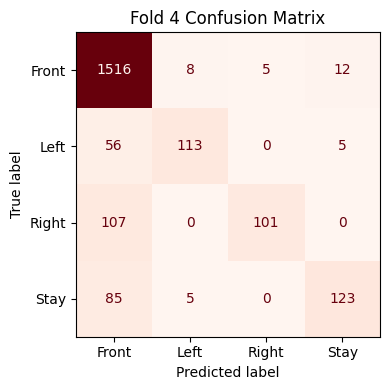

In [5]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt

for fold_idx, (train_idx, test_idx) in enumerate(folds):
    print(f"\n===== Fold {fold_idx} =====")
    X_trainval, y_trainval = X_flat[train_idx], y_flat[train_idx]
    X_test, y_test = X_flat[test_idx], y_flat[test_idx]

    # ✅ train/val 분할
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=42
    )

    # ✅ SVM 정의 및 학습
    model = SVC(kernel='rbf', C=1.0, gamma='scale')
    model.fit(X_train, y_train)

    # ✅ 예측 및 평가
    preds = model.predict(X_test)
    targets = y_test

    cm = confusion_matrix(targets, preds, labels=range(len(label_encoder.classes_)))
    CM_total += cm
    preds_all.extend(preds)
    targets_all.extend(targets)

    # ✅ 출력 및 시각화
    print(classification_report(targets, preds, target_names=label_encoder.classes_, digits=4))

    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=ax, cmap='Reds', colorbar=False, values_format='d')
    ax.set_title(f'Fold {fold_idx} Confusion Matrix')
    plt.tight_layout()
    plt.show()



=== Total confusion matrix ===


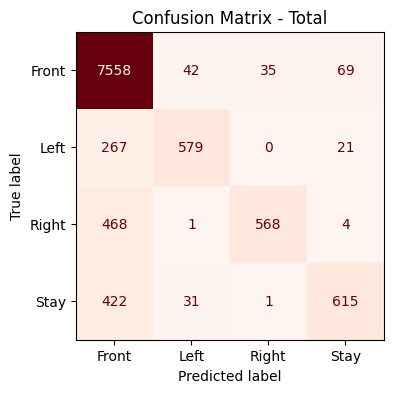

=== Total classification report ===
              precision    recall  f1-score   support

       Front     0.8672    0.9810    0.9206      7704
        Left     0.8867    0.6678    0.7618       867
       Right     0.9404    0.5456    0.6906      1041
        Stay     0.8674    0.5753    0.6918      1069

    accuracy                         0.8726     10681
   macro avg     0.8904    0.6925    0.7662     10681
weighted avg     0.8760    0.8726    0.8624     10681



In [6]:
# ✅ 전체 confusion matrix
print("\n=== Total confusion matrix ===")
fig, ax = plt.subplots(figsize=(4, 4))
disp_total = ConfusionMatrixDisplay(confusion_matrix=CM_total, display_labels=label_encoder.classes_)
disp_total.plot(ax=ax, cmap='Reds', colorbar=False, values_format='d')
plt.title("Confusion Matrix - Total")
plt.show()

# ✅ 전체 classification report
print("=== Total classification report ===")
print(classification_report(targets_all, preds_all, target_names=label_encoder.classes_, digits=4))
